In [ ]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Experiments

> This module contains all the code for running our experiments for Tango.

In [ ]:
#hide
import cv2

import numpy as np

from collections import defaultdict, OrderedDict

from tqdm.auto import tqdm

# tango
from tango.prep import *
from tango.features import *
from tango.eval import *
from tango.cnn import *

from pathlib import Path

from pprint import pprint

from matplotlib import pyplot as plt

from nbdev.showdoc import *

from sklearn.cluster import KMeans

## Setup data

In [ ]:
path = Path("/tf/data/datasets/videos")
video_paths = sorted(path.glob("**/video.mp4"))
imgs = get_rand_imgs(video_paths[0], 30_000, n = 100)

In [ ]:
path = Path("/tf/data/datasets/validation_videos")
vid_ds = VideoDataset.from_path(path).label_from_paths()
vid_ds.get_labels()

['car_part', 'king_james', 'remote']

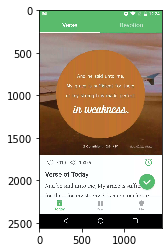

In [ ]:
vid_ds['king_james']['S01'][0].show_frame(0)

## Define different models to run experiments on:
- SIFT baseline model - (M01)
- CNN non-layered non-finetuned baseline model - (M02)
- CNN non-layered finetuned baseline model - (M03)
- CNN layered non-finetuned baseline model - (M04)
- CNN layered finetuned baseline model - (M05)

In [ ]:
# SIFT based models:
M01 = SIFTExtractor(cv2.xfeatures2d.SIFT_create())

# CNN based models:
M02 = CNNExtractor(createExtractor(None, None, 'resnet50', False))
# learn, linear_output_layer = cnn.trainPetsModel() # Need to change to training on android screenshots
# M03 = CNNExtractor(cnn.createExtractor(learn, linear_output_layer, 'resnet50', True))
M04 = CNNExtractor(createLayeredExtractor()) # TODO: Rego over implementation as it doesn't seem to generate multiple visual codebooks
# Need to create code for using finetuned layered cnn model M05

models_under_study = [M01, M02] # [M01, M02, M04]

## Experiment 01
Ability for each model to detect duplicate bug report videos.

**TODO:** Need to vary hyperparameters of different values such as number of visual words to include in codebooks

In [ ]:
model_codebooks = {}
num_vwords = [100,]
for vwords in tqdm(num_vwords):
    for i, model in tqdm(enumerate(models_under_study), total = len(models_under_study)):
        codebook = gen_vcodebook(imgs, model, vwords)
        model_codebooks[f'M{i + 1:02}-{vwords}'] = codebook

/tf/main/tango/features.py:73: ConvergenceWarning: Number of distinct clusters (29) found smaller than n_clusters (100). Possibly due to duplicate points in X.
  codebook.fit(features_list)


In [ ]:
def gen_tfidfs(vid_ds, df):
    vid_tfids = results = defaultdict(
        lambda: defaultdict(list)
    )
    for app, reports in tqdm(vid_ds.labels.items()):
        for i, (report, vids) in enumerate(reports.items()):
            for vid in vids:
                hist, _ = get_bovw(vid.vid_path, model, codebook, vwords, n = 500)
                vid_tfids[app][report].append(calc_tf_idf(hist, df))
    
    return vid_tfids

In [ ]:
def get_results(vid_ds, imgs, models, model_codebooks, num_vwords):
    results = {}
    
    for vwords in num_vwords:
        for m, (model, (key, codebook)) in enumerate(zip(models, model_codebooks.items())):
            results[f'M{m + 1:02}-{vwords}'] = {}
            df = get_df(imgs, model, codebook, vwords)
            vid_tfids = gen_tfidfs(vid_ds, df)
            for app, reports in vid_ds.labels.items():
                results[f'M{m + 1:02}-{vwords}'][app] = {}
                for report_i in reports:
                    results[f'M{m + 1:02}-{vwords}'][app][report_i] = {}
                    for report_j in reports:
                        results[f'M{m + 1:02}-{vwords}'][app][report_i][report_j] = {}
                        for k in range(len(vid_tfids[app][report_i])):
                            results[f'M{m + 1:02}-{vwords}'][app][report_i][report_j][f'vid_{k}'] = {}
                            for l in range(len(vid_tfids[app][report_j])):
                                results[f'M{m + 1:02}-{vwords}'][app][report_i][report_j][f'vid_{k}'][f'vid_{l}'] = np.dot(vid_tfids[app][report_i][k], vid_tfids[app][report_j][l]) / (np.linalg.norm(vid_tfids[app][report_i][k]) * np.linalg.norm(vid_tfids[app][report_j][l]))
    
    return results

In [ ]:
results = get_results(vid_ds, imgs, models_under_study, model_codebooks, num_vwords)

In [ ]:
def flatten_dict(d_in, d_out, parent_key):
    for k, v in d_in.items():
        if isinstance(v, dict):
            flatten_dict(v, d_out, parent_key + (k,))
        else:
            d_out[parent_key + (k,)] = v

In [ ]:
def sort_results(results):
    sorted_results = {}
    for m in results:
        sorted_results[m] = {}
        for app in results[m]:
            sorted_results[m][app] = {}
            d_out = {}
            flatten_dict(results[m][app], d_out, tuple())
            sorted_results[m][app] = OrderedDict(
                sorted(d_out.items(), key=lambda x: x[1], reverse = True)
            )
    
    return sorted_results

In [ ]:
sorted_results = sort_results(results)
pprint(sorted_results['M01-100'])

In [ ]:
evaluate(sorted_results)

NameError: name 'evaluate' is not defined

In [ ]:
for model in sorted_results:
    rs = []
    for app in sorted_results[model]:
        r = []
        for labels, score in sorted_results[model][app].items():
            if labels[0] == 'S01':
                if labels[2] != labels[3]:
                    if labels[0] == labels[1]: r.append(1)
                    else: r.append(0)
        rs.append(r)
    
    print(f'{model} mAP:', mean_average_precision(rs))
    print(f'{model} mRR:', mean_reciprocal_rank(rs))

M01-100 mAP: 0.8471109251649777
M01-100 mRR: 1.0
M02-100 mAP: 0.8345413475487371
M02-100 mRR: 1.0


In [ ]:
mean_reciprocal_rank(rs)

1.0

In [ ]:
mean_reciprocal_rank(rs)

1.0

In [ ]:
mean_average_precision(rs)

0.8345413475487371

In [ ]:
mean_average_precision(rs)

0.8471109251649777

In [ ]:
r1, r2, r3 = [], [], []
for labels, score in sorted_results['M01-100']['car_part'].items():
    if labels[0] == 'S01':
        if labels[2] != labels[3]:
            if labels[0] == labels[1]: r1.append(1)
            else: r1.append(0)

In [ ]:
mean_average_precision([r1, r2, r3])

0.27293913256842317

In [ ]:
average_precision(r1), average_precision(r2), average_precision(r3)

(0.8188173977052695, 0.0, 0.0)

In [ ]:
average_precision(r)

0.8603504307990683

In [ ]:
r2, r3

([0, 0, 0, 0], [0, 0, 0, 0])

In [ ]:
for labels, score in sorted_results['M01-100']['car_part'].items():
    if labels[0] == 'S02':
        print(labels)

('S02', 'S02', 'vid_0', 'vid_0')
('S02', 'S01', 'vid_0', 'vid_0')
('S02', 'S01', 'vid_0', 'vid_2')
('S02', 'S01', 'vid_0', 'vid_4')
('S02', 'S01', 'vid_0', 'vid_3')
('S02', 'S03', 'vid_0', 'vid_0')
('S02', 'S01', 'vid_0', 'vid_1')


In [ ]:
sorted_results['M01-100']['car_part']

OrderedDict([(('S01', 'S01', 'vid_3', 'vid_3'), 1.0000000000000002),
             (('S03', 'S03', 'vid_0', 'vid_0'), 1.0000000000000002),
             (('S01', 'S01', 'vid_1', 'vid_1'), 1.0),
             (('S02', 'S02', 'vid_0', 'vid_0'), 1.0),
             (('S01', 'S01', 'vid_0', 'vid_0'), 0.9999999999999999),
             (('S01', 'S01', 'vid_0', 'vid_2'), 0.9999999999999999),
             (('S01', 'S01', 'vid_0', 'vid_4'), 0.9999999999999999),
             (('S01', 'S01', 'vid_2', 'vid_0'), 0.9999999999999999),
             (('S01', 'S01', 'vid_2', 'vid_2'), 0.9999999999999999),
             (('S01', 'S01', 'vid_2', 'vid_4'), 0.9999999999999999),
             (('S01', 'S01', 'vid_4', 'vid_0'), 0.9999999999999999),
             (('S01', 'S01', 'vid_4', 'vid_2'), 0.9999999999999999),
             (('S01', 'S01', 'vid_4', 'vid_4'), 0.9999999999999999),
             (('S01', 'S02', 'vid_0', 'vid_0'), 0.99998685910322),
             (('S01', 'S02', 'vid_2', 'vid_0'), 0.99998685910322),

In [ ]:
# export
def mean_reciprocal_rank(rs):
    """Score is reciprocal of the rank of the first relevant item

    First element is 'rank 1'.  Relevance is binary (nonzero is relevant).

    Example from http://en.wikipedia.org/wiki/Mean_reciprocal_rank
    >>> rs = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.61111111111111105
    >>> rs = np.array([[0, 0, 0], [0, 1, 0], [1, 0, 0]])
    >>> mean_reciprocal_rank(rs)
    0.5
    >>> rs = [[0, 0, 0, 1], [1, 0, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.75

    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)

    Returns:
        Mean reciprocal rank
    """
    rs = (np.asarray(r).nonzero()[0] for r in rs)
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in rs])

def r_precision(r):
    """Score is precision after all relevant documents have been retrieved

    Relevance is binary (nonzero is relevant).

    >>> r = [0, 0, 1]
    >>> r_precision(r)
    0.33333333333333331
    >>> r = [0, 1, 0]
    >>> r_precision(r)
    0.5
    >>> r = [1, 0, 0]
    >>> r_precision(r)
    1.0

    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)

    Returns:
        R Precision
    """
    r = np.asarray(r) != 0
    z = r.nonzero()[0]
    if not z.size:
        return 0.
    return np.mean(r[:z[-1] + 1])


def precision_at_k(r, k):
    """Score is precision @ k

    Relevance is binary (nonzero is relevant).

    >>> r = [0, 0, 1]
    >>> precision_at_k(r, 1)
    0.0
    >>> precision_at_k(r, 2)
    0.0
    >>> precision_at_k(r, 3)
    0.33333333333333331
    >>> precision_at_k(r, 4)
    Traceback (most recent call last):
        File "<stdin>", line 1, in ?
    ValueError: Relevance score length < k


    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)

    Returns:
        Precision @ k

    Raises:
        ValueError: len(r) must be >= k
    """
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)


def average_precision(r):
    """Score is average precision (area under PR curve)

    Relevance is binary (nonzero is relevant).

    >>> r = [1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
    >>> delta_r = 1. / sum(r)
    >>> sum([sum(r[:x + 1]) / (x + 1.) * delta_r for x, y in enumerate(r) if y])
    0.7833333333333333
    >>> average_precision(r)
    0.78333333333333333

    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)

    Returns:
        Average precision
    """
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)


def mean_average_precision(rs):
    """Score is mean average precision

    Relevance is binary (nonzero is relevant).

    >>> rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1]]
    >>> mean_average_precision(rs)
    0.78333333333333333
    >>> rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1], [0]]
    >>> mean_average_precision(rs)
    0.39166666666666666

    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)

    Returns:
        Mean average precision
    """
    return np.mean([average_precision(r) for r in rs])


In [ ]:
pd.DataFrame.from_dict(results['M02-100']['car_part']['S01'])

,S01,S02,S03
vid_0,"{'vid_0': 1.0, 'vid_1': 0.9952221132818684, 'v...",{'vid_0': 0.9708095769094802},{'vid_0': 0.9734365052512393}
vid_1,"{'vid_0': 0.9952221132818684, 'vid_1': 1.0, 'v...",{'vid_0': 0.960270188297443},{'vid_0': 0.9605124346621617}
vid_2,"{'vid_0': 1.0, 'vid_1': 0.9952221132818684, 'v...",{'vid_0': 0.9708095769094802},{'vid_0': 0.9734365052512393}
vid_3,"{'vid_0': 0.9973006427455489, 'vid_1': 0.99945...",{'vid_0': 0.9648970227613424},{'vid_0': 0.965622793408852}
vid_4,"{'vid_0': 1.0, 'vid_1': 0.9952221132818684, 'v...",{'vid_0': 0.9708095769094802},{'vid_0': 0.9734365052512393}


In [ ]:
results['M02-100']['car_part']['S01']

{'S01': {'vid_0': {'vid_0': 1.0,
   'vid_1': 0.9952221132818684,
   'vid_2': 1.0,
   'vid_3': 0.9973006427455489,
   'vid_4': 1.0},
  'vid_1': {'vid_0': 0.9952221132818684,
   'vid_1': 1.0,
   'vid_2': 0.9952221132818684,
   'vid_3': 0.9994501965866164,
   'vid_4': 0.9952221132818684},
  'vid_2': {'vid_0': 1.0,
   'vid_1': 0.9952221132818684,
   'vid_2': 1.0,
   'vid_3': 0.9973006427455489,
   'vid_4': 1.0},
  'vid_3': {'vid_0': 0.9973006427455489,
   'vid_1': 0.9994501965866164,
   'vid_2': 0.9973006427455489,
   'vid_3': 1.0000000000000002,
   'vid_4': 0.9973006427455489},
  'vid_4': {'vid_0': 1.0,
   'vid_1': 0.9952221132818684,
   'vid_2': 1.0,
   'vid_3': 0.9973006427455489,
   'vid_4': 1.0}},
 'S02': {'vid_0': {'vid_0': 0.9708095769094802},
  'vid_1': {'vid_0': 0.960270188297443},
  'vid_2': {'vid_0': 0.9708095769094802},
  'vid_3': {'vid_0': 0.9648970227613424},
  'vid_4': {'vid_0': 0.9708095769094802}},
 'S03': {'vid_0': {'vid_0': 0.9734365052512393},
  'vid_1': {'vid_0': 0.960

('S01', 'S01', 'vid_3', 'vid_3') 1.0000000000000002
('S01', 'S01', 'vid_1', 'vid_1') 1.0
('S01', 'S01', 'vid_0', 'vid_0') 0.9999999999999999
('S01', 'S01', 'vid_0', 'vid_2') 0.9999999999999999
('S01', 'S01', 'vid_0', 'vid_4') 0.9999999999999999
('S01', 'S01', 'vid_2', 'vid_0') 0.9999999999999999
('S01', 'S01', 'vid_2', 'vid_2') 0.9999999999999999
('S01', 'S01', 'vid_2', 'vid_4') 0.9999999999999999
('S01', 'S01', 'vid_4', 'vid_0') 0.9999999999999999
('S01', 'S01', 'vid_4', 'vid_2') 0.9999999999999999
('S01', 'S01', 'vid_4', 'vid_4') 0.9999999999999999
('S01', 'S02', 'vid_0', 'vid_0') 0.99998685910322
('S01', 'S02', 'vid_2', 'vid_0') 0.99998685910322
('S01', 'S02', 'vid_4', 'vid_0') 0.99998685910322
('S01', 'S03', 'vid_3', 'vid_0') 0.9999816898742376
('S01', 'S01', 'vid_0', 'vid_3') 0.9957921935849146
('S01', 'S01', 'vid_2', 'vid_3') 0.9957921935849146
('S01', 'S01', 'vid_3', 'vid_0') 0.9957921935849146
('S01', 'S01', 'vid_3', 'vid_2') 0.9957921935849146
('S01', 'S01', 'vid_3', 'vid_4') 

0.7981741318870876

In [ ]:
# TODO Reduce frames per second (try difference numbers)

In [ ]:
# sorted_results = sort_results(results)
pprint(sorted_results['M01-100']['car_part'])

OrderedDict([(('S01', 'S01', 'vid_3', 'vid_3'), 1.0000000000000002),
             (('S03', 'S03', 'vid_0', 'vid_0'), 1.0000000000000002),
             (('S01', 'S01', 'vid_1', 'vid_1'), 1.0),
             (('S02', 'S02', 'vid_0', 'vid_0'), 1.0),
             (('S01', 'S01', 'vid_0', 'vid_0'), 0.9999999999999999),
             (('S01', 'S01', 'vid_0', 'vid_2'), 0.9999999999999999),
             (('S01', 'S01', 'vid_0', 'vid_4'), 0.9999999999999999),
             (('S01', 'S01', 'vid_2', 'vid_0'), 0.9999999999999999),
             (('S01', 'S01', 'vid_2', 'vid_2'), 0.9999999999999999),
             (('S01', 'S01', 'vid_2', 'vid_4'), 0.9999999999999999),
             (('S01', 'S01', 'vid_4', 'vid_0'), 0.9999999999999999),
             (('S01', 'S01', 'vid_4', 'vid_2'), 0.9999999999999999),
             (('S01', 'S01', 'vid_4', 'vid_4'), 0.9999999999999999),
             (('S01', 'S02', 'vid_0', 'vid_0'), 0.99998685910322),
             (('S01', 'S02', 'vid_2', 'vid_0'), 0.99998685910322),

In [ ]:
pprint(sorted_results['M02-100'])

{'car_part': OrderedDict([(('S02', 'S02', 'vid_0', 'vid_0'),
                           1.0000000000000002),
                          (('S01', 'S01', 'vid_0', 'vid_0'), 1.0),
                          (('S01', 'S01', 'vid_0', 'vid_2'), 1.0),
                          (('S01', 'S01', 'vid_0', 'vid_4'), 1.0),
                          (('S01', 'S01', 'vid_1', 'vid_1'), 1.0),
                          (('S01', 'S01', 'vid_2', 'vid_0'), 1.0),
                          (('S01', 'S01', 'vid_2', 'vid_2'), 1.0),
                          (('S01', 'S01', 'vid_2', 'vid_4'), 1.0),
                          (('S01', 'S01', 'vid_4', 'vid_0'), 1.0),
                          (('S01', 'S01', 'vid_4', 'vid_2'), 1.0),
                          (('S01', 'S01', 'vid_4', 'vid_4'), 1.0),
                          (('S03', 'S03', 'vid_0', 'vid_0'), 1.0),
                          (('S01', 'S01', 'vid_3', 'vid_3'),
                           0.9999999999999998),
                          (('S01', 'S02', 'vi

In [ ]:
def get_results(vid_ds, imgs, models, model_codebooks, num_vwords):
    results = defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(
                lambda: defaultdict(
                    lambda: defaultdict(
                        lambda: defaultdict(float)
                    )
                )
            )
        )
    )
    
    for vwords in num_vwords:
        for i, (model, (key, codebook)) in enumerate(zip(models, model_codebooks.items())):
            df = get_df(imgs, model, codebook, vwords)
            for app, reports in vid_ds.labels.items():
                for report_i, vids_i in reports.items():
                    for report_j, vids_j in reports.items():
                        for j, vid_i in enumerate(vids_i):
                            for k, vid_j in enumerate(vids_j):
                                hist_1, bovw_1 = get_bovw(vid_i.vid_path, model, codebook, vwords, n = 100)
                                tf_idf_1 = calc_tf_idf(hist_1, df)
                                hist_2, bovw_2 = get_bovw(vid_j.vid_path, model, codebook, vwords, n = 100)
                                tf_idf_2 = calc_tf_idf(hist_2, df)
                                results[f'M{i + 1:02}-{vwords}'][app][report_i][report_j][f'vid_{j}'][f'vid_{k}'] = np.dot(tf_idf_1, tf_idf_2) / (np.linalg.norm(tf_idf_1) * np.linalg.norm(tf_idf_2))
    
    return results

In [ ]:
results = get_results(vid_ds, imgs, models_under_study, model_codebooks, num_vwords); results

In [ ]:
results['M01-100']['king_james']['S01']

In [ ]:
hist, bovw = get_bovw(vid_ds['king_james']['S01'][0].vid_path, M01, model_codebooks['00-100'], 100, 100)

In [ ]:
#hide
plt.bar(range(vwords), hist)
plt.show()